<a href="https://colab.research.google.com/github/nxbisgin/CovidVaccineSideEffectsFromTwitter/blob/main/CovidVaccineSideEffectsFromTwitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Business Understanding:
For this project I used to Twitter data to find answers to the following questions:
1. Which side effects are more rare/common after a COVID shot?
2. What is the possiblity that your COVID shot is largely uneventful?
3. Can social media aid as a way to track rare/unknown side effects? (National healthcare officials are taking each and every report of adverse side effects seriously https://www.nbcnews.com/health/health-news/covid-vaccine-safety-system-has-gaps-may-miss-unexpected-side-n1265986?utm_source=facebook&utm_medium=news_tab&utm_content=algorithm)

# Data Understanding

https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets

The data is collected using tweepy Python package to access Twitter API. 

Dates: 12/31/2020 - 08/16/2021

Data size: 67 MB

In [2]:
!pip install tweet-preprocessor
import nltk
nltk.download('punkt')
import pandas as pd
import preprocessor as p
import re
from nltk.tokenize import word_tokenize
import itertools
import collections
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# reading in csv file
df = pd.read_csv('/content/drive/MyDrive/CoVaxSideEffect/vaccination_all_tweets.csv')
print("There are "+str(len(df))+" tweets in the dataset")

There are 168224 tweets in the dataset


In [7]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [6]:
pd.set_option('display.max_colwidth', None)
df.text.head()

0                                               Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1    While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm
2    #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3    Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
4         Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq
Name: text, dtype: object

# Prepare Data

Removed urls, emojis, numbers, punctuation marks and any word that is less than 3 character long.

Converted all to lowercase.

In [8]:
# function to clean tweets tweet preprocessor library
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.NUMBER)
def clean_text(input_str):
  '''
  Cleans tweet text, removes urls, numbers, white spaces
  Parameters: input_str (tweet text to be cleaned)
  Returns: input_str (clenaed text)
  '''
  input_str = input_str.lower()
  input_str = p.clean(input_str) #tweet preprocessor library
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  input_str = url_pattern.sub(r'', input_str) #remove url
  input_str = input_str.replace("#", "").replace("_", " ") #remove all # and _ signs
  input_str = re.sub(r'[^\w]', ' ',input_str)
  input_str = ''.join(i for i in input_str if not i.isdigit())
  input_str = re.sub(r'\s+', ' ',   input_str)  # Eliminate duplicate whitespaces using wildcards
  input_str = re.sub(r'(?:^| )\w(?:$| )', ' ', input_str).strip() #removes any single letter words
  input_str = input_str.lstrip()
  return input_str

# actually cleaning tweets
tweets = list(df['text'])
for i in range(0, len(tweets)):
  tweets[i] = clean_text(tweets[i])
df['cleaned_tweets'] = tweets

In [9]:
pd.set_option('display.max_colwidth', None)
df.cleaned_tweets[1120:1140]

1120                               covid vaccination in uk over citizens receive first dose of pfizer biontech vaccine
1121                the french national authority for health said on thursday it has approved the vaccine developed by
1122        this year has drained health care workers know will be emotional when get to grhospitalkw and get my first
1123                                                  serbian pm ms brnabic serbianpm receiving pfizerbiontech vaccine
1124                        what an amazing full circle moment trustscience katalinkariko pfizervaccine pfizerbiontech
1125                              lethal injection pfizerbiontech pfizercovidvaccine potassiumchloride lethalinjection
1126           check out my latest article when the pediatrician has vaccine hesitancy my journey to the covid vaccine
1127            today our first healthcarehero wei xu personal support worker psw at unionvilla received the first dos
1128                                            

(-0.5, 999.5, 499.5, -0.5)

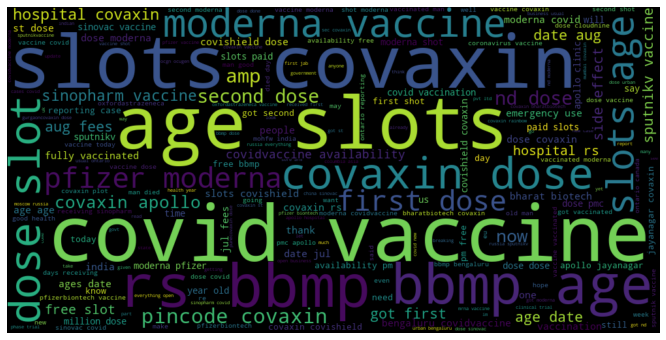

In [ ]:
from wordcloud import WordCloud
words = ' '.join([word for word in df['cleaned_tweets']])
word_cloud = WordCloud(width=1000, height=500, random_state=20, max_font_size=120).generate(words)

fig, ax = plt.subplots(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

# Filtering for Side Effect Related Tweets

In [11]:
def plot_word_counts(df):
  '''
  Tokenize data, count side effect related words and plot the word counts
  '''
  # apply tokenization
  df['tokenized'] = df['cleaned_tweets'].apply(word_tokenize)
  tweets = df['tokenized'].tolist()
  tweets = [x for x in tweets if x]
  # Flatten list of words in clean tweets
  all_words = list(itertools.chain(*tweets))
  # Create counter of words in clean tweets
  counts= collections.Counter(all_words)
  counts_df = pd.DataFrame(counts.most_common(5000),columns=['words', 'count'])
  counts_df = counts_df.sort_values(by='count')
  counts_df=counts_df[counts_df['words'].str.contains("pain|redness|swelling|swollen|sore|tender|shievering|rash|covid arm|itch|fatigue|aching|tired|chill|fever|nausea|cough|lymph|vomit|shiever|myocarditis|pericarditis|diarrhea|cough|breath|vision|spot|stomach|Guillain|difficulty|bladder|blood|clot|heart|inflammation|period|menstrual|bleeding|taste|smell|congestion|nose|muscle|chest|confusion|wake|skin|rash|flulike|headache")]
  counts_df=counts_df[counts_df['count']>49]
  #Becase we are searching for pain, the word spain shows up in results
  #Eliminate unrelated words
  counts_df=counts_df[counts_df['words']!='maharashtra']
  counts_df=counts_df[counts_df['words']!='cmomaharashtra']
  counts_df=counts_df[counts_df['words']!='reaches']
  counts_df=counts_df[counts_df['words']!='spain']
  counts_df=counts_df[counts_df['words']!='bitch']
  counts_df=counts_df[counts_df['words']!='teaching']
  counts_df=counts_df[counts_df['words']!='sponsored']
  counts_df=counts_df[counts_df['words']!='hemantsorenjmm']
  counts_df=counts_df[counts_df['words']!='switch']
  counts_df=counts_df[counts_df['words']!='reaching']
  counts_df=counts_df[counts_df['words']!='asking']
  tot_ct=counts_df['count'].sum()
  fig, ax = plt.subplots(figsize=(12, 12))
  # Plot horizontal bar graph
  counts_df.plot.barh(x='words', y='count',ax=ax,color="purple")
  title = "Side Effect Related Words in Tweets"
  ax.set_title(title)
  for i, v in enumerate(counts_df['count']):
      mystr=str(v)+" (%"+str(int(v/tot_ct*100))+")"
      plt.text(v, i, " "+mystr, color='blue', va='center', fontweight='bold')
  plt.show()
  plt.savefig(title)

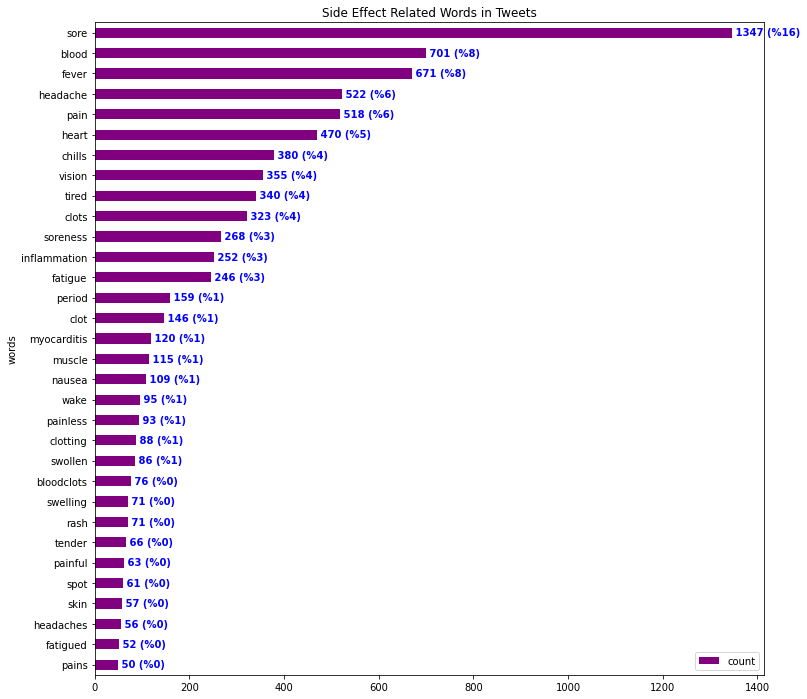

<Figure size 432x288 with 0 Axes>

In [12]:
plot_word_counts(df)

# Question 1

According to the results, people mentioned the word "sore" in 16% of the side effect related tweets and the word "soreness" in 3%, which is possibly referring to the "sore arm" or "soreness in the arm". If the words "swollen", "swelling" and "tender" are also included in this category (with the assumption that they are used to describe the pain in the arm), **swollen or sore arm** makes **22%** of all the reported side effects**.
**Fever** was reported in **8%** of the side effect related tweets and **chills** was reported in **4%** of them. **Headache** was reported **7%** of the time (combination of words "headache" and "headaches"). **Fatigue** was another common side effect making **8%** of all reported side effects (combination of words "tired", "fatigue" and "fatigued"). Also, **blood clots** were mentioned in **8%** of them (combination of words "bloodclot", "clots", "clot" and "clotting"). **Heart** was mentioned in **5%** of the tweets and **vision** was mentioned in **4%**, which may indicate a problems related to heart and vision.

# Question 2
On the other hand, **1%** of the related tweets used the word "**painless**", so we understand that there were some lucky people who reported a pain free experience.

## Question 3
Other side effects mentioned are: **inflammation (3%), myocarditis (1%), some problem about periods (1%) and nausea (1%)**. These are some of the rare side effects and Twitter data may aid in tracking these side effects.

# Evaluation

Overall, I was able to find answers to my questions using Twitter data. I was able to find the most common side effects reported by Twitter users, rare side effects and the possibilty of having a pain free experience.